# BÖLÜM 0: Veri Kümesi Hakkında
Veri Kümesi Hakkında
Kullanılan veri kümesi, Kaliforniya’daki konut değerleriyle ilgili çeşitli özellikleri içermektedir. Veri kümesinde tipik olarak şu sütunlar bulunur:
* longitude: Konumun boylam değeri
* latitude: Konumun enlem değeri
* housing_median_age: Bölgedeki konutların medyan yaşı
* total_rooms: Toplam oda sayısı
* total_bedrooms: Toplam yatak odası sayısı
* population: Bölgede yaşayan toplam nüfus
* households: Hane sayısı
* median_income: Medyan gelir (10.000$ cinsinden yaklaşık bir ölçü)
* median_house_value: Konut değerlerinin medyanı (hedef değer / label)
* ocean_proximity: Okyanusa yakınlık bilgisi (kategorik)






# BÖLÜM 1: PySpark Kurulumu ve Spark Oturumunun Başlatılması


In [ ]:
# Spark kurulumu ve gerekli kütüphanelerin import edilmesi
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sqrt, isnan, when, count, log1p
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Imputer
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

spark = SparkSession.builder.appName("AdvancedCaliforniaHousingRegression").getOrCreate()
print("Spark oturumu başlatıldı!")


Spark oturumu başlatıldı!


# BÖLÜM 2: Veri Yükleme ve İlk İnceleme
* h**eader=True** parametresi, ilk satırın sütun isimlerini içerdiğini belirtir.
* **inferSchema=True** parametresi, Spark’ın sütun veri tiplerini otomatik olarak algılamasını sağlar.
****

**Neden bu yöntem?**

 Spark, büyük veri kümelerini paralel işlemede oldukça etkilidir ve inferSchema ile veri tipleri otomatik tanınarak sütun türleri (Integer, Double vs.) daha doğru şekilde belirlenir.

In [ ]:
# Veri yükleme ve ilk inceleme
# Bu kod, CSV dosyasını okuyarak veri şemasını ve ilk 5 satırı gösterir.

data_path = "/content/housing.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True) .

print("Veri Şeması:")
data.printSchema()

print("İlk 5 Satır:")
data.show(5)


Veri Şeması:
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

İlk 5 Satır:
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|      

# BÖLÜM 3: Eksik Değerlerin Kontrolü ve Doldurulması (Impute)

Bu bölümde, `total_bedrooms` sütunundaki eksik değerler kontrol edilmekte ve doldurulmaktadır.

1. **Eksik Değerlerin Kontrolü:**  
   - `isnan` ve `isNull` fonksiyonları kullanılarak `total_bedrooms` sütunundaki eksik değerlerin sayısı belirlenir.  
   - Bu işlem, veri temizliği sürecinin başlangıcında veri kalitesini değerlendirmek için önemlidir.

2. **Eksik Değerlerin Doldurulması:**  
   - `Imputer` sınıfı kullanılarak, eksik değerler sütunun medyan değeri ile doldurulur.  
   - Medyan stratejisi, uç değerlerden etkilenmediği için eksik verilerin doldurulmasında tercih edilir.

3. **Sütun Yeniden Adlandırma:**  
   - İmpute işleminden sonra orijinal `total_bedrooms` sütunu kaldırılır.  
   - Doldurulan sütun, `total_bedrooms_imputed` adından `total_bedrooms` olarak yeniden adlandırılır.  
   - Bu adım, veri setindeki sütun isimlerinin tutarlılığını sağlar.

4. **İmpute İşlemi Sonrası Kontrol:**  
   - Doldurma işleminden sonra, tekrar eksik değer kontrolü yapılarak tüm eksik değerlerin giderildiği doğrulanır.



In [ ]:
# total_bedrooms sütunundaki eksik değerlerin kontrolü
missing_count = data.select(
    count(when(isnan("total_bedrooms") | col("total_bedrooms").isNull(), "total_bedrooms")).alias("missing_count")
).collect()[0]["missing_count"]
print(f"total_bedrooms sütununda {missing_count} eksik değer vardı.")

# Eksik değerleri median stratejisi ile doldurma
imputer = Imputer(inputCols=["total_bedrooms"], outputCols=["total_bedrooms_imputed"]).setStrategy("median")
data = imputer.fit(data).transform(data)
data = data.drop("total_bedrooms").withColumnRenamed("total_bedrooms_imputed", "total_bedrooms")
print("Eksik değerler dolduruldu: total_bedrooms sütunu impute edildi.")

# İmpute sonrası eksik değer kontrolü
missing_count = data.select(
    count(when(isnan("total_bedrooms") | col("total_bedrooms").isNull(), "total_bedrooms")).alias("missing_count")
).collect()[0]["missing_count"]
print(f"total_bedrooms sütununda {missing_count} eksik değer vardı.")


total_bedrooms sütununda 207 eksik değer vardı.
Eksik değerler dolduruldu: total_bedrooms sütunu impute edildi.
total_bedrooms sütununda 0 eksik değer vardı.


# BÖLÜM 4: Aykırı Değer Filtreleme

Bu bölümde, veri kümesinde yer alan aykırı değerler filtrelenmektedir.

1. **Etiket Sütunu için Üst Sınır:**  
   - `median_house_value` sütunu, hedef değişken olarak kullanılmaktadır.  
   - Bu sütundaki değerlerin belirli bir üst sınırın (500001) üzerinde olması, veri kümesinde çok nadir görülen ve model eğitimini olumsuz etkileyebilecek uç değerler oluşturabilir.  
   - Bu nedenle, `data.filter(col("median_house_value") < 500001)` ifadesi ile bu uç değerler veri kümesinden çıkarılır.

2. **Gelir Sütunu için Aykırı Değer Kırpması:**  
   - `median_income` sütununda, aşırı yüksek gelir değerleri bulunabilir.  
   - `data.filter(col("median_income") < 15)` ifadesi, aşırı yüksek değerleri kırparak, modelin daha stabil öğrenmesini sağlar.

3. **Filtreleme Sonucu:**  
   - Her iki filtre uygulandıktan sonra, veri kümesinde sadece model için uygun aralıktaki veriler kalır.
   - Bu adım, modelin genel performansını artırmak ve uç değerlerden kaynaklanabilecek hataları minimize etmek açısından önemlidir.


In [ ]:
# Aykırı değerler için filtreleme:
# - Etiket (median_house_value) için üst sınır
# - median_income için aşırı yüksek değerlerin kırpılması
data = data.filter(col("median_house_value") < 500001)
data = data.filter(col("median_income") < 15)
print("Aykırı değer filtreleme tamamlandı.")

Aykırı değer filtreleme tamamlandı.


# BÖLÜM 5: Log Dönüşümleri ve Feature Engineering

Bu bölümde, veriler üzerinde log dönüşümleri ve ek özellikler (feature engineering) uygulanmaktadır.

1. **Log1p Dönüşümleri:**  
   - `total_rooms`, `total_bedrooms`, `population`, `households` ve `median_income` sütunlarına `log1p` fonksiyonu uygulanır.  
   - Bu dönüşüm, yüksek değerlerin model eğitimine olan etkisini azaltarak, verilerin daha normal dağılım göstermesine yardımcı olur.

2. **Ek Özellikler Oluşturma:**  
   - **bedrooms_per_room:** Yatak odası sayısının toplam oda sayısına oranı hesaplanarak, evlerin oda dağılımı hakkında bilgi elde edilir.  
   - **population_per_room:** Nüfusun toplam oda sayısına oranı, yaşam alanı yoğunluğunu ortaya koyar.  
   - **rooms_per_household:** Toplam oda sayısının hane sayısına oranı, her haneye düşen oda sayısı bilgisini verir.  
   - **distance_to_center:** Coğrafi konum verileri kullanılarak, belirli bir merkez noktasına (örneğin, şehir merkezi) uzaklık hesaplanır. Bu özellik, konut değerlerini etkileyen konum faktörlerini yansıtır.

3. **Hedef Değişkenin Yeniden İsimlendirilmesi:**  
   - `median_house_value` sütunu, modelin hedef değişkeni olarak kullanılacağından, daha açıklayıcı olması için `label` olarak yeniden adlandırılır.



In [ ]:
# Log1p dönüşümleri: total_rooms, total_bedrooms, population, households, median_income
data = data.withColumn("log_total_rooms", log1p(col("total_rooms")))
data = data.withColumn("log_total_bedrooms", log1p(col("total_bedrooms")))
data = data.withColumn("log_population", log1p(col("population")))
data = data.withColumn("log_households", log1p(col("households")))
data = data.withColumn("log_median_income", log1p(col("median_income")))

# Ek özellikler oluşturma:
data = data.withColumn("bedrooms_per_room", col("total_bedrooms") / col("total_rooms"))
data = data.withColumn("population_per_room", col("population") / col("total_rooms"))
data = data.withColumn("rooms_per_household", col("total_rooms") / col("households"))
data = data.withColumn("distance_to_center", sqrt((col("longitude") + 122.23)**2 + (col("latitude") - 37.88)**2))

# Hedef değişkenin yeniden isimlendirilmesi
data = data.withColumnRenamed("median_house_value", "label")
print("Feature engineering adımları tamamlandı.")


Feature engineering adımları tamamlandı.


# BÖLÜM 6: Özellik Dönüşümleri ve Ölçeklendirme

Bu bölümde, veri setindeki özelliklerin makine öğrenmesi modellerinde kullanılabilir hale getirilmesi için gerekli dönüşümler uygulanmaktadır.

1. **Kategorik Değişken Dönüşümü:**  
   - `ocean_proximity` sütunu, önce `StringIndexer` kullanılarak sayısal değerlere dönüştürülür.  
   - Ardından, `OneHotEncoder` kullanılarak her bir kategori için ayrı bir sütun oluşturulur.  
   - Bu işlem, kategorik verilerin model tarafından doğru yorumlanmasını sağlar.

2. **Numeric Özelliklerin Belirlenmesi:**  
   - Log dönüşümleri ve ek özellikler (feature engineering) sonrasında elde edilen sayısal sütunlar `numeric_features` listesinde toplanır.  
   - Bu liste, modelin eğitiminde kullanılacak temel sayısal özellikleri içerir.

3. **Vektörleştirme (VectorAssembler):**  
   - `VectorAssembler`, belirlenen numeric özellikleri tek bir sütun altında birleştirir.  
   - Bu işlem, verilerin makine öğrenmesi modellerine uygun formatta hazırlanmasını sağlar.

4. **Özellik Ölçeklendirme (StandardScaler):**  
   - `StandardScaler` kullanılarak numeric özelliklerin ortalaması 0 ve standart sapması 1 olacak şekilde ölçeklendirilir.  
   - Bu adım, özellikle lineer modellerde, farklı ölçeklerdeki değişkenlerin etkisini dengelemek için önemlidir.

5. **Final Özellik Birleştirme:**  
   - Ölçeklendirilmiş numeric özellikler ile one-hot encode edilmiş kategorik veriler, `final_assembler` ile birleştirilerek `features` sütununu oluşturur.  
   - Bu sütun, modelin eğitiminde kullanılacak nihai öznitelik vektörünü temsil eder.



In [ ]:
# Kategorik değişken dönüşümü: ocean_proximity
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")
encoder = OneHotEncoder(inputCols=["ocean_proximity_index"], outputCols=["ocean_proximity_vec"])

# Numeric özellikler listesi (log dönüşümlü sütunlar kullanılıyor)
numeric_features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "log_total_rooms",
    "log_total_bedrooms",
    "log_population",
    "log_households",
    "log_median_income",
    "bedrooms_per_room",
    "population_per_room",
    "rooms_per_household",
    "distance_to_center"
]

# Numeric özellikleri birleştiren VectorAssembler
assembler_numeric = VectorAssembler(inputCols=numeric_features, outputCol="numeric_features")

# Özellik ölçeklendirme (StandardScaler)
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features", withStd=True, withMean=True)

# Tüm özellikleri birleştiren final assembler (ölçeklendirilmiş numeric + kategorik)
final_assembler = VectorAssembler(inputCols=["scaled_numeric_features", "ocean_proximity_vec"], outputCol="features")
print("Öznitelik dönüşümleri ve ölçeklendirme tamamlandı.")


Öznitelik dönüşümleri ve ölçeklendirme tamamlandı.


# BÖLÜM 7: Exploratory Data Analysis (EDA) ve Görselleştirmeler

Bu bölümde, Spark DataFrame'den 1000 satırlık örnek veri alınarak Pandas DataFrame'e dönüştürülmekte ve ardından çeşitli görselleştirmeler yapılmaktadır.
1. **Örnek Veri Dönüştürme:**  
   - Spark DataFrame'den 1000 satır alınarak `toPandas()` fonksiyonu ile Pandas DataFrame'e dönüştürülür.  

2. **Histogram: Label Dağılımı:**  
   - `label` (Median House Value) sütununun dağılımı, 30 bin ile histogram olarak çizilir.  
   - Bu grafik, konut değerlerinin dağılımını ve uç değerlerin varlığını gözler önüne serer.

3. **Histogram: Log(Median Income) Dağılımı:**  
   - `log_median_income` sütununu kullanarak, gelir dağılımı incelenir.  
   - Bu grafik, log dönüşümü sonrası gelir verisinin dağılımını gösterir.

4. **Scatter Plot: Housing Median Age vs. Log(Median Income):**  
   - `housing_median_age` ile `log_median_income` arasındaki ilişki, saçılma grafiği (scatter plot) ile görselleştirilir.  
   - Bu grafik, konutların yaşı ile gelir arasındaki ilişkiyi ortaya koyar.

5. **Özellikler Arası Korelasyon Isı Haritası:**  
   - Numeric özellikler ve `label` sütunu arasındaki korelasyon hesaplanır ve `seaborn` kütüphanesi kullanılarak ısı haritası çizilir.  
   - Bu harita, öznitelikler arasındaki ilişkilerin kuvvetini ve yönünü görsel olarak sunar, böylece hangi özelliklerin modelde daha etkili olabileceği analiz edilebilir.

  ***Not: Belki bunlara gerek yoktu fakat ben datayı anlamayı ve onu incelemeyi sevdiğim için ekledim hocam.***

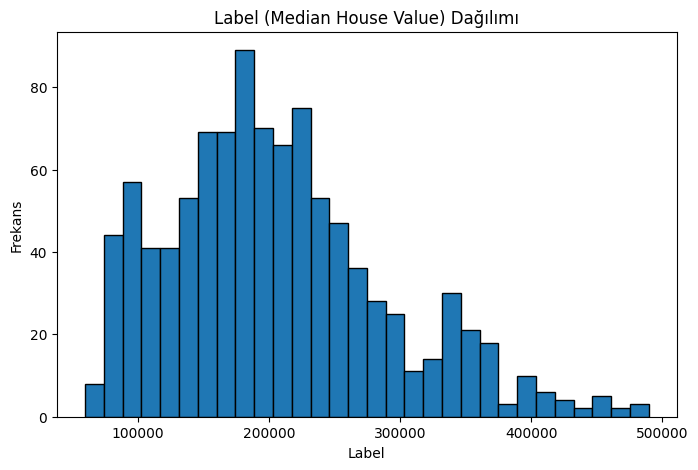

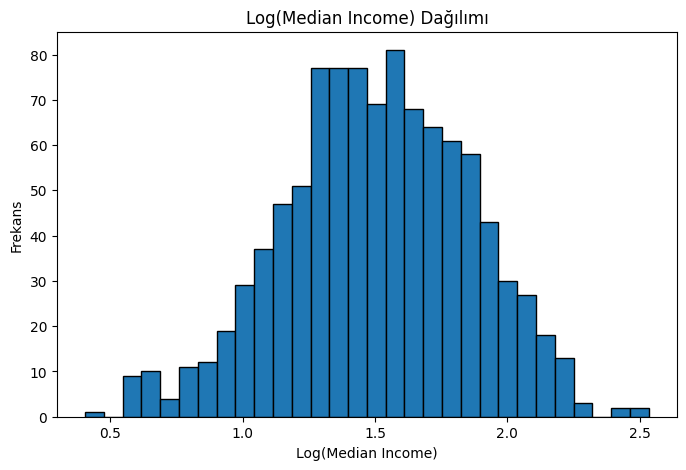

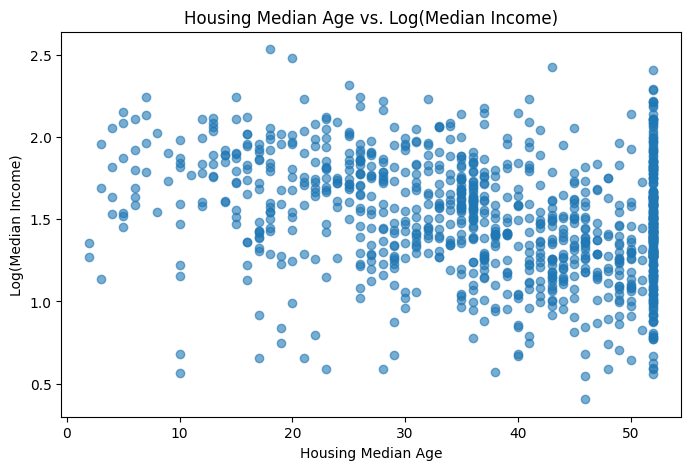

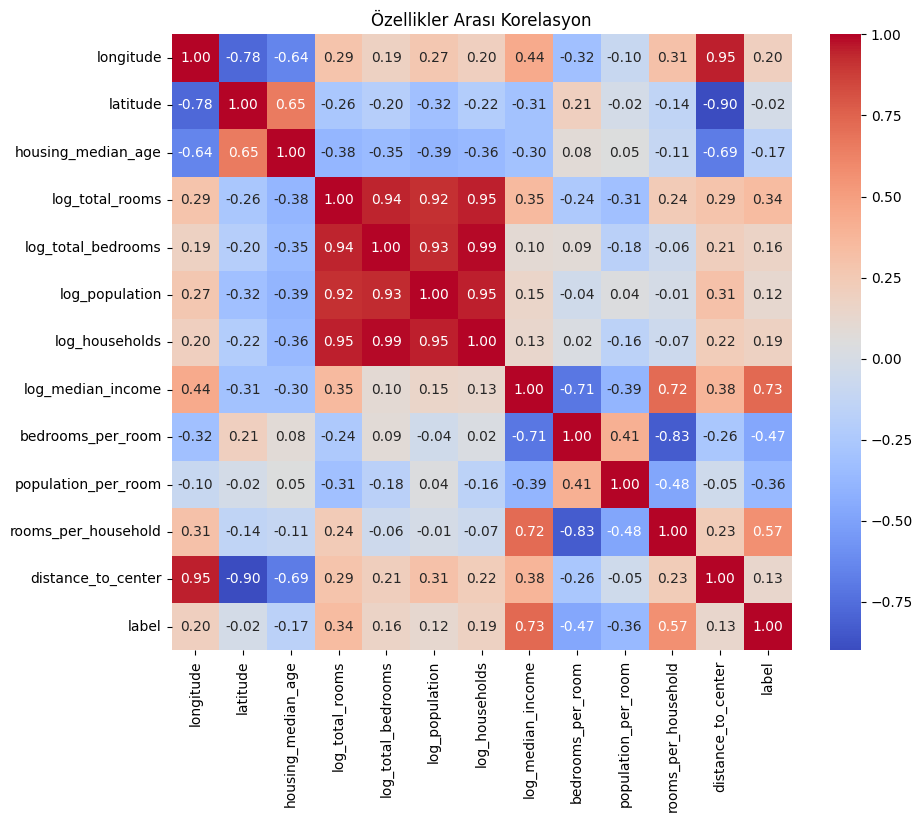

In [ ]:
# Spark DataFrame'den örnek veri alarak Pandas DataFrame'e dönüştürme (örnek 1000 satır)
data_sample = data.limit(1000).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Histogram: Hedef değişken (label)
plt.figure(figsize=(8,5))
plt.hist(data_sample["label"], bins=30, edgecolor='k')
plt.title("Label (Median House Value) Dağılımı")
plt.xlabel("Label")
plt.ylabel("Frekans")
plt.show()

# Histogram: Log(Median Income)
plt.figure(figsize=(8,5))
plt.hist(data_sample["log_median_income"], bins=30, edgecolor='k')
plt.title("Log(Median Income) Dağılımı")
plt.xlabel("Log(Median Income)")
plt.ylabel("Frekans")
plt.show()

# Scatter Plot: Housing Median Age vs. Log(Median Income)
plt.figure(figsize=(8,5))
plt.scatter(data_sample["housing_median_age"], data_sample["log_median_income"], alpha=0.6)
plt.title("Housing Median Age vs. Log(Median Income)")
plt.xlabel("Housing Median Age")
plt.ylabel("Log(Median Income)")
plt.show()

# Özellikler arası korelasyon ısı haritası
plt.figure(figsize=(10,8))
corr = data_sample[numeric_features + ["label"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Özellikler Arası Korelasyon")
plt.show()


# BÖLÜM 8: Model Tanımlama ve Pipeline Oluşturulması

Bu bölümde, makine öğrenmesi modelleri tanımlanmakta ve veri ön işleme adımlarıyla birlikte Pipeline yapısı oluşturulmaktadır.
1. **Model Tanımlamaları:**  
   - **Linear Regression (LR):**  
     `LinearRegression` modeli, `features` sütunu üzerinden hedef değişkeni (`label`) tahmin eder.  
     `maxIter=100` parametresi ile eğitimde maksimum iterasyon sayısı belirlenir.  
     
   - **Random Forest Regressor (RF):**  
     `RandomForestRegressor`, karar ağaçları tabanlı topluluk (ensemble) yöntemidir.  
     `seed=42` parametresi, sonuçların tekrarlanabilir olması için rastgelelik kontrolünü sağlar.
     
   - **Gradient Boosted Trees Regressor (GBT):**  
     `GBTRegressor`, zayıf tahminleyicilerin ardışık olarak birleşerek hataları azaltmayı hedefler.  
     `seed=42` parametresi yine tekrarlanabilirlik sağlar.
     
2. **Pipeline Oluşturulması:**  
   - Her bir model için, veri ön işleme adımları (kategorik değişken dönüşümü, vektörleştirme, ölçeklendirme vs.) içeren bir Pipeline tanımlanır.  
   - Pipeline, model eğitiminde tüm işlemlerin sıralı ve tutarlı bir şekilde uygulanmasını garanti eder.



In [ ]:
# Modellerin tanımlanması
lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=100)
rf = RandomForestRegressor(featuresCol="features", labelCol="label", seed=42)
gbt = GBTRegressor(featuresCol="features", labelCol="label", seed=42)

# Pipeline'ların oluşturulması (ön işlem adımları + model)
pipeline_lr = Pipeline(stages=[indexer, encoder, assembler_numeric, scaler, final_assembler, lr])
pipeline_rf = Pipeline(stages=[indexer, encoder, assembler_numeric, scaler, final_assembler, rf])
pipeline_gbt = Pipeline(stages=[indexer, encoder, assembler_numeric, scaler, final_assembler, gbt])
print("Pipeline'lar oluşturuldu.")


Pipeline'lar oluşturuldu.


# BÖLÜM 9: Veri Setinin Eğitim ve Test Olarak Bölünmesi

In [ ]:
# Verinin %80 eğitim, %20 test olarak bölünmesi
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
print("Veri eğitim ve test setlerine bölündü.")


Veri eğitim ve test setlerine bölündü.


# BÖLÜM 10: Hyperparameter Grid ve CrossValidator Ayarları

Bu bölümde, her model için hiperparametre grid'leri oluşturulmuş ve 5 katlı Cross-Validation ile modelin genelleme performansını artıracak ayarlar yapılmıştır.

1. **Hiperparametre Grid Oluşturma:**  
   - **Linear Regression:**  
     - `regParam` (regularization parametresi) ve `elasticNetParam` (L1 ve L2 ceza oranı) değerleri için farklı kombinasyonlar belirlenmiştir.  
   - **Random Forest:**  
     - Ağaç derinliği (`maxDepth`) ve ağaç sayısı (`numTrees`) için farklı değerler belirlenmiştir.  
   - **Gradient Boosting:**  
     - `maxDepth` ve `maxIter` (iterasyon sayısı) için alternatif değerler oluşturulmuştur.  
   - Bu grid'ler, her modelin hiperparametre uzayında optimum değerleri bulmaya yardımcı olur.

2. **Evaluator:**  
   - `RegressionEvaluator` kullanılarak, modelin performansını ölçmek için RMSE (Root Mean Squared Error) metriği belirlenmiştir.  
   - RMSE, hataların karekök ortalamasını alarak modelin tahmin hatasını gösterir.

3. **CrossValidator Ayarları:**  
   - Her model için, oluşturulan pipeline ve hiperparametre grid'i kullanılarak 5 katlı Cross-Validation ayarlanmıştır.  
   - `parallelism=2` ayarı, işlemlerin paralel olarak çalıştırılarak eğitim süresinin kısaltılmasını sağlar.  
   - Cross-Validation, modelin farklı veri alt kümelerinde performansını değerlendirerek, overfitting riskini azaltır ve daha güvenilir sonuçlar elde edilmesine yardımcı olur.




In [ ]:
# Linear Regression için hyperparameter grid
param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Random Forest için hyperparameter grid
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.numTrees, [50, 100]) \
    .build()

# Gradient Boosting için hyperparameter grid
param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [50, 100]) \
    .build()

# Evaluator: RMSE metriği
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# CrossValidator ayarları (5 katlı CV)
cv_lr = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=param_grid_lr, evaluator=evaluator, numFolds=5, parallelism=2)
cv_rf = CrossValidator(estimator=pipeline_rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=5, parallelism=2)
cv_gbt = CrossValidator(estimator=pipeline_gbt, estimatorParamMaps=param_grid_gbt, evaluator=evaluator, numFolds=5, parallelism=2)
print("Parametre grid'leri ve CrossValidator ayarları yapılandırıldı.")


Parametre grid'leri ve CrossValidator ayarları yapılandırıldı.


# BÖLÜM 11: Modellerin Eğitilmesi (Cross-Validation)

In [ ]:
print("Linear Regression eğitiliyor...")
model_lr = cv_lr.fit(train_data)

print("Random Forest eğitiliyor...")
model_rf = cv_rf.fit(train_data)

print("Gradient Boosting Trees eğitiliyor...")
model_gbt = cv_gbt.fit(train_data)

# Cross-Validation sonuçlarının yazdırılması
print("\nCV Sonuçları:")
print("Linear Regression CV RMSE ortalaması:", model_lr.avgMetrics)
print("Random Forest CV RMSE ortalaması:", model_rf.avgMetrics)
print("Gradient Boosting Trees CV RMSE ortalaması:", model_gbt.avgMetrics)


Linear Regression eğitiliyor...
Random Forest eğitiliyor...
Gradient Boosting Trees eğitiliyor...

CV Sonuçları:
Linear Regression CV RMSE ortalaması: [62513.60453246321, 62513.60453246321, 62513.60453246321, 62513.58003329353, 62578.44881009289, 62583.486632867345, 62513.360617841616, 62605.760232967055, 62587.13760751601]
Random Forest CV RMSE ortalaması: [57464.11358592403, 57475.51006653232, 47067.94567311379, 46894.30640794445, 44878.49056850531, 44591.27990789064]
Gradient Boosting Trees CV RMSE ortalaması: [46961.56723228641, 45194.59071398416, 52902.13740274221, 52930.15104756205]


# BÖLÜM 12: Test Verisi Üzerinde Tahmin ve Model Performans Değerlendirmesi

In [ ]:
# Test verisi üzerinde tahminlerin yapılması
predictions_lr = model_lr.transform(test_data)
predictions_rf = model_rf.transform(test_data)
predictions_gbt = model_gbt.transform(test_data)

# Performans değerlendirme fonksiyonu
def evaluate_model(predictions, model_name):
    rmse = evaluator.evaluate(predictions)
    mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae").evaluate(predictions)
    r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(predictions)
    print(f"\n{model_name} Performansı:")
    print(f"  RMSE: {rmse}")
    print(f"  MAE: {mae}")
    print(f"  R2: {r2}")
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

results_lr = evaluate_model(predictions_lr, "Linear Regression")
results_rf = evaluate_model(predictions_rf, "Random Forest")
results_gbt = evaluate_model(predictions_gbt, "Gradient Boosting Trees")



Linear Regression Performansı:
  RMSE: 64634.71403529417
  MAE: 46432.55394180622
  R2: 0.57324535316714

Random Forest Performansı:
  RMSE: 44570.355263381374
  MAE: 30323.546832086464
  R2: 0.79707348968939

Gradient Boosting Trees Performansı:
  RMSE: 45019.62577002918
  MAE: 30900.57126588216
  R2: 0.7929618604169666


# BÖLÜM 13: Model Performanslarının Karşılaştırılması ve Görselleştirilmesi


En iyi model: Random Forest (RMSE: 44570.355263381374)


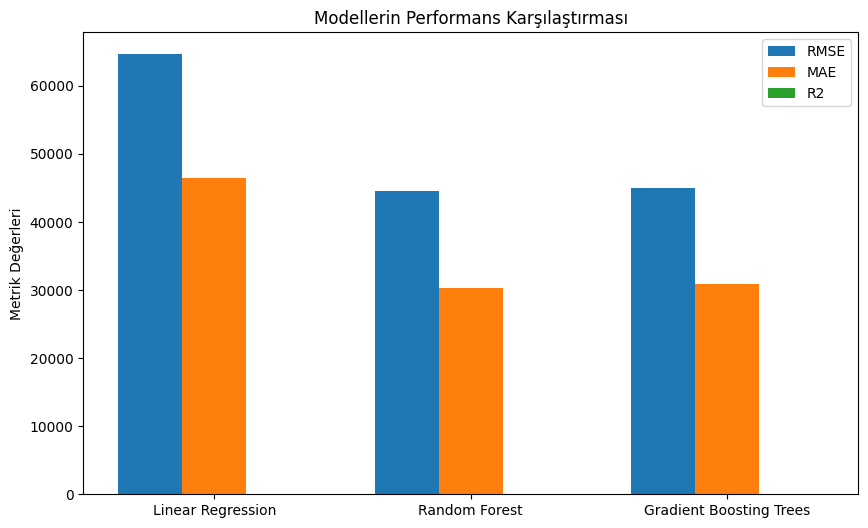

In [ ]:
# RMSE değerine göre en iyi modelin belirlenmesi
models_rmse = {
    "Linear Regression": results_lr["RMSE"],
    "Random Forest": results_rf["RMSE"],
    "Gradient Boosting Trees": results_gbt["RMSE"]
}
best_model_name = min(models_rmse, key=models_rmse.get)
print(f"\nEn iyi model: {best_model_name} (RMSE: {models_rmse[best_model_name]})")

# Model performans metriklerinin bar grafiği ile görselleştirilmesi
import numpy as np

model_names = list(models_rmse.keys())
rmse_values = [results_lr["RMSE"], results_rf["RMSE"], results_gbt["RMSE"]]
mae_values = [results_lr["MAE"], results_rf["MAE"], results_gbt["MAE"]]
r2_values = [results_lr["R2"], results_rf["R2"], results_gbt["R2"]]

x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, rmse_values, width, label='RMSE')
plt.bar(x, mae_values, width, label='MAE')
plt.bar(x + width, r2_values, width, label='R2')
plt.xticks(x, model_names)
plt.ylabel("Metrik Değerleri")
plt.title("Modellerin Performans Karşılaştırması")
plt.legend()
plt.show()


# BÖLÜM 14: En İyi Modelin Parametreleri ve Öznitelik Önemlerinin Görselleştirilmesi

En iyi Random Forest parametreleri:
  maxDepth: 15
  numTrees: 100


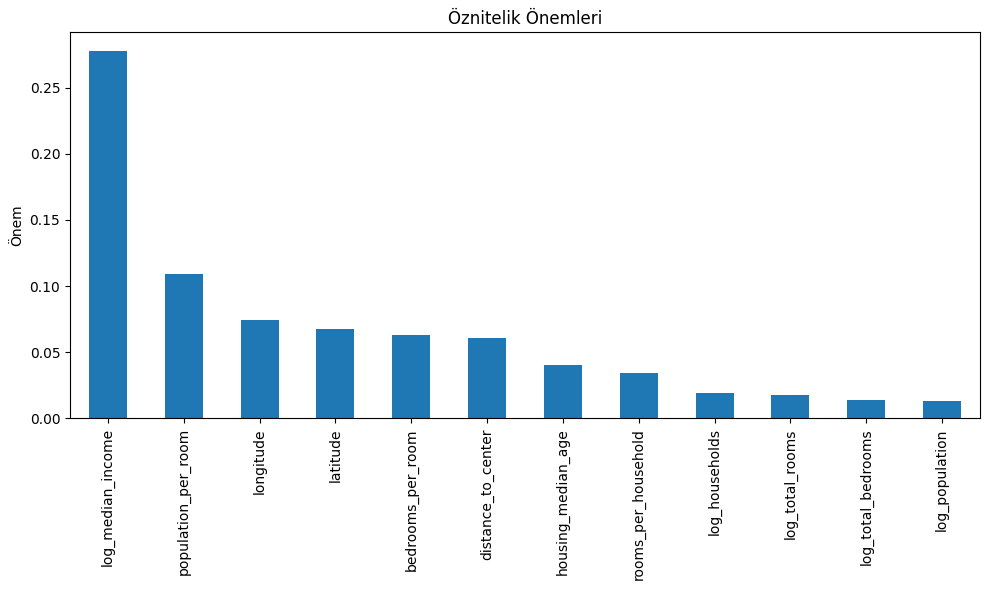

In [ ]:
if best_model_name == "Linear Regression":
    best_stage = model_lr.bestModel.stages[-1]
    print("En iyi Linear Regression parametreleri:")
    print(f"  regParam: {best_stage._java_obj.getRegParam()}")
    print(f"  elasticNetParam: {best_stage._java_obj.getElasticNetParam()}")
elif best_model_name == "Random Forest":
    best_stage = model_rf.bestModel.stages[-1]
    print("En iyi Random Forest parametreleri:")
    print(f"  maxDepth: {best_stage.getOrDefault('maxDepth')}")
    print(f"  numTrees: {best_stage.getNumTrees}")
    feature_importances = best_stage.featureImportances
elif best_model_name == "Gradient Boosting Trees":
    best_stage = model_gbt.bestModel.stages[-1]
    print("En iyi GBT parametreleri:")
    print(f"  maxDepth: {best_stage.getOrDefault('maxDepth')}")
    print(f"  maxIter: {best_stage.getOrDefault('maxIter')}")
    feature_importances = best_stage.featureImportances

# Ağaç tabanlı modellerde, numeric özellikler üzerinden öznitelik önemlerinin görselleştirilmesi
if best_model_name in ["Random Forest", "Gradient Boosting Trees"]:
    fi_array = feature_importances.toArray()
    # Numeric özellikler listesi sırasıyla eşleşiyor (log dönüşümlü sütunlar dahil)
    import pandas as pd
    fi_pd = pd.Series(fi_array[:len(numeric_features)], index=numeric_features)
    fi_pd = fi_pd.sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    fi_pd.plot(kind="bar")
    plt.title("Öznitelik Önemleri")
    plt.ylabel("Önem")
    plt.tight_layout()
    plt.show()
